In [12]:
#!pip install autokeras


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.datasets import load_files
from tensorflow.keras.datasets import mnist
import autokeras as ak

import plotly.express as px
import copy 
import os
import json

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

To make this tutorial easy to follow, we just treat MNIST dataset as a
regression dataset. It means we will treat prediction targets of MNIST dataset,
which are integers ranging from 0 to 9 as numerical values, so that they can be
directly used as the regression targets.

## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an
example


In [25]:
data = pd.read_csv('new_multiclasses.csv')
data = data[data['mos2'] > 0]

In [26]:
lable_count = dict(data['Y'].value_counts())
lable_count

{'ps1+ps2+multi': 5142,
 'ps2+multi': 2558,
 'ps1+multi': 2550,
 'ps1+ps2+multi+ice': 869,
 'ps2+multi+ice': 420,
 'ps1+multi+ice': 397,
 'ps1+ps2': 48,
 'ps1': 27,
 'ps2': 22,
 'ps1+ps2+ice': 18,
 'ps2+multi+ice+badice': 4,
 'ps1+ice': 4,
 'ps2+ice': 3,
 'ps1+ps2+multi+ice+badice': 2,
 'ps1+multi+ice+badice': 2}

In [27]:
new_data = pd.concat([data[data['Y']==y][:100] if lable_count[y]>100 else data[data['Y']==y] for y in np.unique(data['Y'])])
new_data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
325,fake_00336.pgm,0,1,0,0,0,0,0.834543,0.672156,ps1
388,fake_00405.pgm,0,1,0,0,0,0,0.873979,0.606771,ps1
409,fake_00429.pgm,0,1,0,0,0,0,0.841170,0.713611,ps1
930,fake_01069.pgm,0,1,0,0,0,0,0.702128,0.847937,ps1
1404,fake_01756.pgm,0,1,0,0,0,0,0.883778,0.513013,ps1
...,...,...,...,...,...,...,...,...,...,...
6019,fake_08555.pgm,0,0,1,1,1,0,0.850695,0.815657,ps2+multi+ice
13,fake_00014.pgm,0,0,1,1,1,1,0.516343,0.681703,ps2+multi+ice+badice
46,fake_00047.pgm,0,0,1,1,1,1,0.822762,0.710859,ps2+multi+ice+badice
114,fake_00115.pgm,0,0,1,1,1,1,0.603269,0.832699,ps2+multi+ice+badice


In [28]:
imgs = []
imgs_arr = []
imgs_drop = []
for f in new_data['file']:
    f = f.replace('pgm','png')
    try:
        image = tf.keras.preprocessing.image.load_img("./training_data/{}".format(f), color_mode='grayscale') 
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        imgs.append(image)
        imgs_arr.append(image_array)
    except:
        imgs_drop.append(f)
print(len(imgs_drop))

0


In [29]:
input_arr = np.array(imgs_arr)  # Convert single image to a batch.
print(type(input_arr))
print(input_arr.shape)
x_train = np.squeeze(input_arr)
print(x_train.shape)

y_train = np.array(new_data['mos2'])
print(y_train.shape)

X = x_train
Y = y_train

<class 'numpy.ndarray'>
(730, 512, 512, 1)
(730, 512, 512)
(730,)


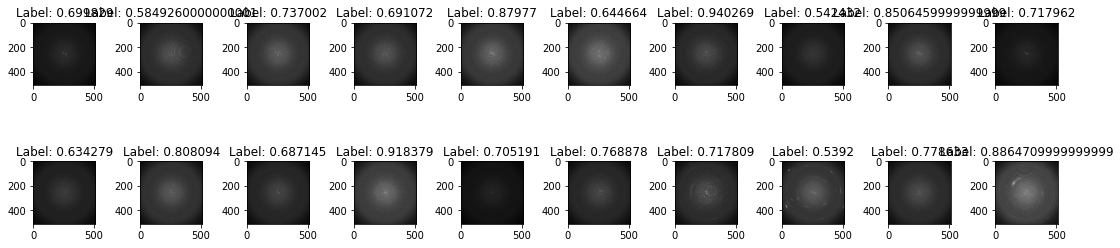

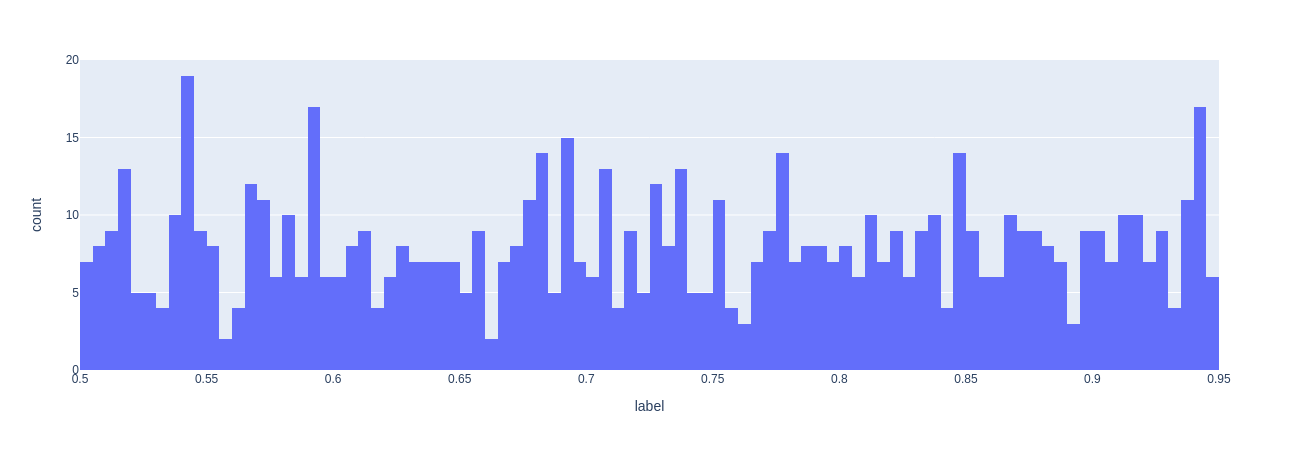

In [30]:
import matplotlib.pyplot as plt
num = 20
k=np.random.randint(len(y_train))
images = x_train[k:(k+num)]
labels = y_train[k:(k+num)]
num_row = 2
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

import plotly.express as px
df = pd.DataFrame(y_train, columns=['label'])
fig = px.histogram(df, x='label', nbins=100)
fig.show()

The second step is to run the ImageRegressor.  It is recommended have more
trials for more complicated datasets.  This is just a quick demo of MNIST, so
we set max_trials to 1.  For the same reason, we set epochs to 2.  You can also
leave the epochs unspecified for an adaptive number of epochs.


In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
# Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, directory='image_regressor2', max_trials=2)
# Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=10)


# Predict with the best model.
predicted_y = reg.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))

Trial 2 Complete [00h 58m 00s]
val_loss: 0.09780475497245789

Best val_loss So Far: 0.09780475497245789
Total elapsed time: 01h 57m 09s
Epoch 1/10
19/19 [==============================] - 393s 20s/step - loss: 19664.6524 - mean_squared_error: 19664.6524
Epoch 2/10
19/19 [==============================] - 385s 20s/step - loss: 748.9387 - mean_squared_error: 748.9387
Epoch 3/10
19/19 [==============================] - 363s 19s/step - loss: 75.8489 - mean_squared_error: 75.8489
Epoch 4/10
19/19 [==============================] - 362s 19s/step - loss: 108.3570 - mean_squared_error: 108.3570
Epoch 5/10
19/19 [==============================] - 363s 19s/step - loss: 4.1694 - mean_squared_error: 4.1694
Epoch 6/10
19/19 [==============================] - 361s 19s/step - loss: 5.1435 - mean_squared_error: 5.1435
Epoch 7/10
19/19 [==============================] - 364s 19s/step - loss: 1.4279 - mean_squared_error: 1.4279
Epoch 8/10
19/19 [==============================] - 368s 19s/step - loss: 1.

In [40]:
model = reg.export_model()
model.summary()

display(hyper_table(path='image_regressor2/image_regressor'))
y_score = model.predict(x_test)
y_score_train = model.predict(x_train)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512)]   0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 512, 512)     0           input_1[0][0]                    
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 512, 512, 1)  0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 1)  3           expand_last_dim[0][0]            
______________________________________________________________________________________________

,trial#1,trial#2
image_block_1/normalize,True,True
image_block_1/augment,True,False
image_block_1/block_type,resnet,resnet
image_block_1/res_net_block_1/pretrained,False,False
image_block_1/res_net_block_1/version,resnet50,resnet50
image_block_1/res_net_block_1/imagenet_size,False,False
regression_head_1/dropout,0,0
optimizer,adam,adam
learning_rate,0.001,0.001
image_block_1/image_augmentation_1/translation_factor,0,NaN


In [37]:
predic_error_analysis(x_train, y_train, y_score_train, x_test, y_test, y_score)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [47]:
def predic_error_analysis(x_train, y_train, y_score_train, x_test, y_test, y_score):
    df1 = pd.DataFrame(y_train)
    df1['obs'] = list(y_train)
    df1['predict'] = y_score_train
    df1['data'] = 'Train'
    #display(df1)
    df2 = pd.DataFrame(y_test)
    df2['obs'] = y_test
    df2['predict'] = y_score
    df2['data'] = 'Test'
    #display(df2)
    df3 = pd.concat([df1,df2])

    fig = px.scatter(
        df3, x='obs', y='predict',
        marginal_x='histogram', marginal_y='histogram',
        color='data', trendline='ols'
    )
    fig.update_traces(histnorm='probability', selector={'type':'histogram'})
    fig.add_shape(
        type="line", line=dict(dash='dash'),
        x0=df3['obs'].min(), y0=df3['obs'].min(),
        x1=df3['obs'].max(), y1=df3['obs'].max()
    )
    fig.update_layout(title="Prediction Error Analysis", 
                      yaxis=dict(range=[df3['obs'].min(), df3['obs'].max()]),
                      xaxis=dict(range=[df3['obs'].min(), df3['obs'].max()]),
                      width=1000, height=1000)
    fig.show()


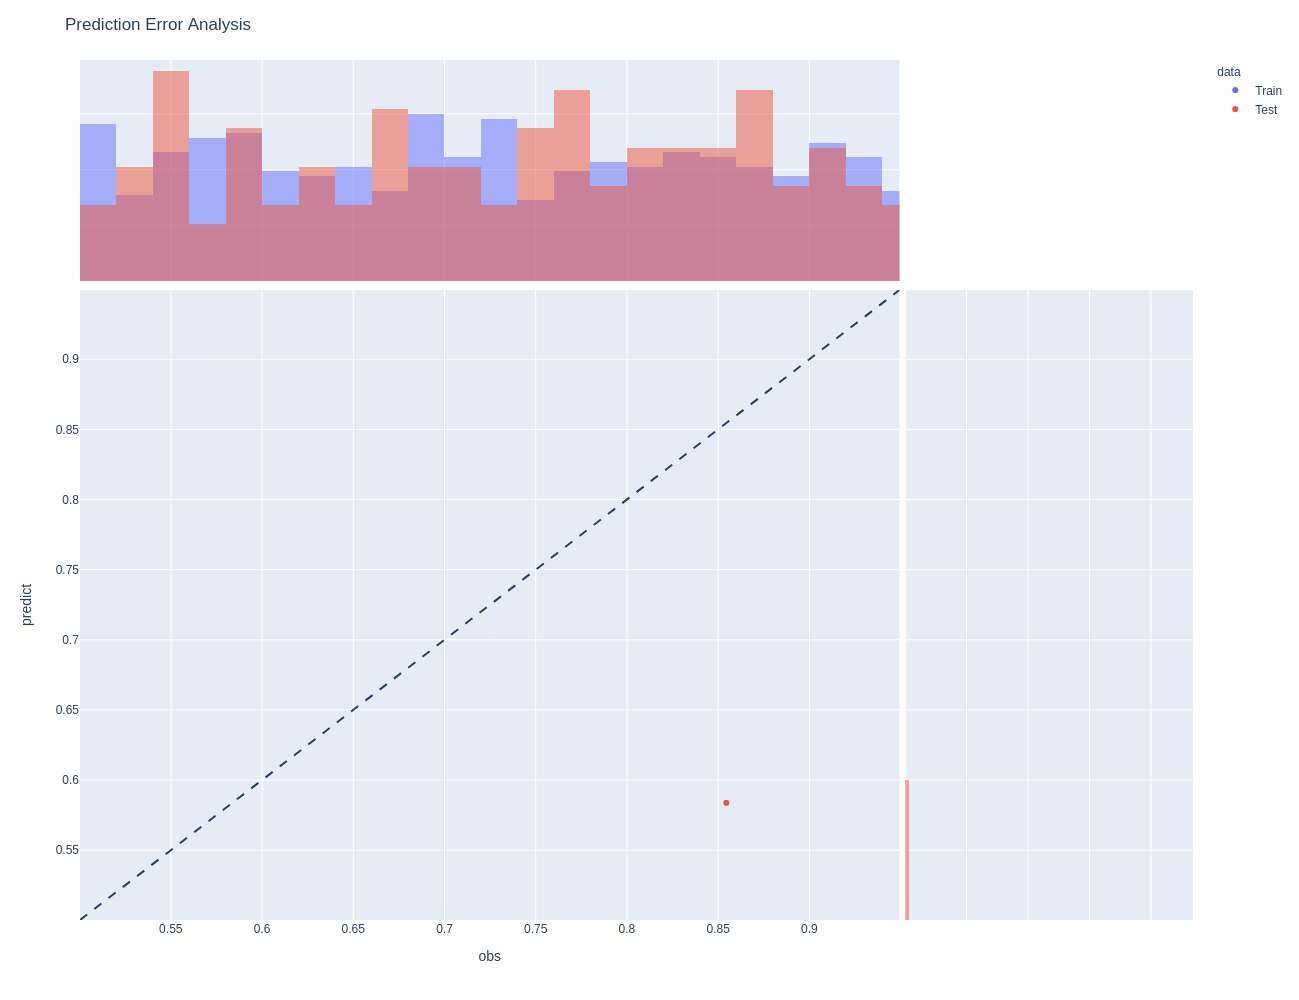

In [48]:
predic_error_analysis(x_train, y_train, y_score_train, x_test, y_test, y_score)